# Introduction
This notebook goes from (preprocessed) EEG data extraction to the fit of the HsMM-MVPA model in multiple conditions

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import itertools
import multiprocessing
import os
import mne
import pyhsmm_mvpa as hsmm

cpus = multiprocessing.cpu_count()
print(cpus)

%load_ext autoreload
%autoreload 2


16


# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [2]:
hsmm.read_mne_EEG#Note the use of filtering and minimum and minimum both for epoch size and RTs, default values will likely not always be a good fit

<function pyhsmm_mvpa.read_mne_EEG(pfiles, event_id, resp_id, sfreq, events=None, tmin=-0.2, tmax=2.2, offset_after_resp=0.1, low_pass=0.5, high_pass=30, upper_limit_RT=2, lower_limit_RT=0.2)>

In [30]:
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213,
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events
sfreq = 100#For resampling
cpus = 5 #if not enough RAM to load all participants data, better reduce the number of processes

path = '/home/gweindel/owncloud/projects/PHD/ForceEEG_2021/processing_EEG/preprocessed_data/'
subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(path) if 'preprocessed' in x]
print(subj_names)
subj_files = [path+ 'preprocessed_'+x+'.fif' for x in subj_names]

save_file = 'epoch_data_condition-wise.nc'
if save_file not in os.listdir():#avoids to loop again if notebook is restarted
    with multiprocessing.Pool(processes=cpus) as pool:
        epoch_data = pool.starmap(hsmm.read_mne_EEG, 
        zip([[x] for x in subj_files], itertools.repeat(event_id), itertools.repeat(resp_id),    
                itertools.repeat(sfreq), itertools.repeat(None), itertools.repeat(-.25), itertools.repeat(2), 
                itertools.repeat(.05), itertools.repeat(1), itertools.repeat(30), itertools.repeat(2), 
                itertools.repeat(.25)))
    
    epoch_data = xr.concat(epoch_data, pd.Series(subj_names, name="participant"),
                          fill_value={'event':'', 'data':np.nan})#not sure about the order of the particiapnt use with caution
    epoch_data.to_netcdf(save_file)
    epoch_data = xr.open_dataset(save_file)#For an unknown reason I need to re-read it
else:
    epoch_data = xr.open_dataset(save_file)
cpus = multiprocessing.cpu_count()

raw = mne.io.read_raw_fif(subj_files[0], preload=False, verbose=False)#loading for sensor position

['S6', 'S18', 'S20', 'S1', 'S16', 'S14', 'S7', 'S15', 'S2', 'S3', 'S4', 'S5', 'S17', 'S10', 'S8', 'S12', 'S9', 'S11', 'S13']


/tmp/ipykernel_246325/4255612793.py:31: RuntimeWarning: This filename (/home/gweindel/owncloud/projects/PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(subj_files[0], preload=False, verbose=False)#loading for sensor position


In [4]:
epoch_data

<xarray.Dataset>
Dimensions:      (epochs: 2370, samples: 200, participant: 19, electrodes: 64)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 ... 2364 2365 2366 2367 2368 2369
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * electrodes   (electrodes) object 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * participant  (participant) object 'S6' 'S18' 'S20' 'S1' ... 'S9' 'S11' 'S13'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 ...
    event        (participant, epochs) object ...
Attributes:
    sfreq:    100.0

Applying standardization, variance scaling and PCA

In [5]:
hsmm_dat, PCs = hsmm.transform_data(epoch_data,'participant',return_weights=True, n_comp=10)

# Applying HsMM for the speed condition

Initializing data for the speed condition

In [6]:
subset = hsmm_dat.where(epoch_data.event.str.contains('speed'),drop=True)
hsmm_speed_data = hsmm.stack_data(subset,'participant')
init_speed = hsmm.hsmm(hsmm_speed_data.data.T, hsmm_speed_data.starts.data, hsmm_speed_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [7]:
bests_speed = init_speed.backward_estimation()
bests_speed

Estimating parameters for 5 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:471: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:477: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 5 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Estimating pa

<xarray.Dataset>
Dimensions:      (n_bumps: 5, stage: 6, params: 2, component: 10, bump: 5,
                  samples: 193, trial: 20204)
Coordinates:
  * n_bumps      (n_bumps) int64 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -1.248e+05 -7.995e+04 ... -7.873e+04
    parameters   (n_bumps, stage, params) float64 2.0 2.974 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.4258 0.2645 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

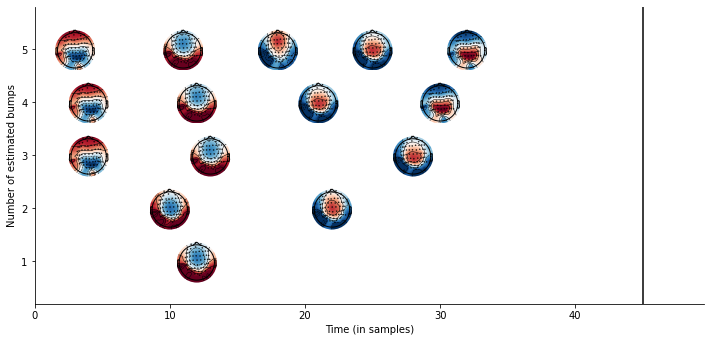

In [8]:
hsmm.plot_topo_timecourse(init_speed, hsmm_speed_data, PCs, bests_speed, raw, magnify=2)

In [9]:
temp = hsmm_speed_data.unstack().data
bests = bests_speed
init = init_speed

subjects_idx = epoch_data.participant.values
likelihoods_loo = []
cpus=5
all_n_bumps = []
for n_bumps in np.arange(1,init_speed.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)

loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})
loocv_speed=loocv

Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating p

Plotting LOOCV along with pvalues from the sign test

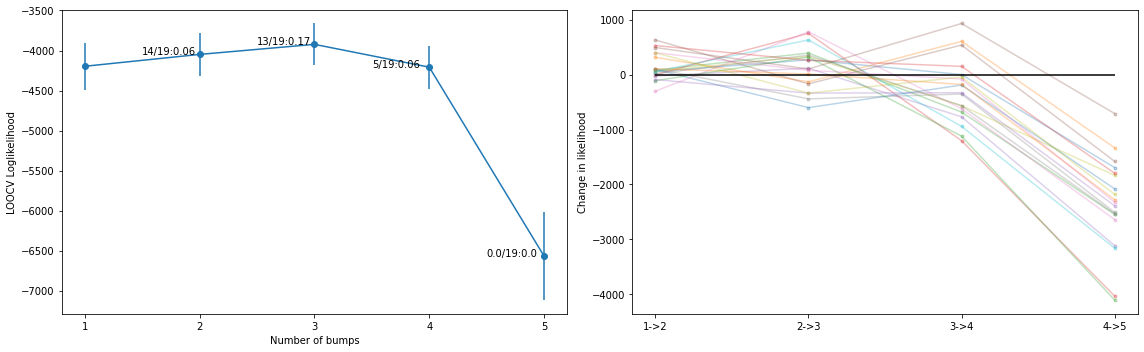

In [10]:
hsmm.plot_LOOCV(loocv_speed)

# Applying HsMM for the accuracy condition

Initializing data for the accuracy condition

In [11]:
subset = hsmm_dat.where(epoch_data.event.str.contains('accuracy'),drop=True)
hsmm_accuracy_data = hsmm.stack_data(subset,'participant')
init_accuracy = hsmm.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

In [12]:
init_accuracy = hsmm.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [13]:
bests_accuracy = init_accuracy.backward_estimation()
bests_accuracy

Estimating parameters for 5 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:469: UserWarning: Using default parameters value for gamma parameters
  try:
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:475: UserWarning: Using default parameters value for magnitudes
  try:


Parameters estimated for 5 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Estimating pa

<xarray.Dataset>
Dimensions:      (n_bumps: 5, stage: 6, params: 2, component: 10, bump: 5,
                  samples: 200, trial: 20965)
Coordinates:
  * n_bumps      (n_bumps) int64 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -1.025e+05 -8.42e+04 ... -9.175e+04
    parameters   (n_bumps, stage, params) float64 2.0 2.756 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.8303 0.5429 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

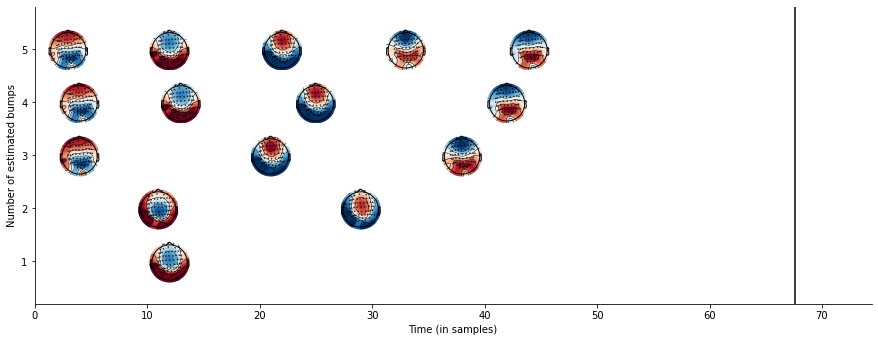

In [14]:
hsmm.plot_topo_timecourse(init_accuracy, hsmm_accuracy_data, PCs, bests_accuracy, raw, magnify=2, figsize=(15,5))

In [15]:
temp = hsmm_accuracy_data.unstack().data
bests = bests_accuracy
init = init_accuracy

subjects_idx = epoch_data.participant.values
likelihoods_loo = []
cpus=5
all_n_bumps = []
for n_bumps in np.arange(1,init.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)

loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})

loocv_accuracy = loocv
loocv_accuracy

Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps modelEstimating parameters for 1 bumps model

Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating 

<xarray.DataArray (n_bump: 5, participants: 19)>
array([[-4925.69199485, -5457.43943366, -5853.77651663, -5093.30219538,
        -4386.20230677, -4534.41014192, -5343.17352301, -4723.16353743,
        -3472.9247983 , -5794.35546665, -3642.53985131, -5659.73643154,
        -4371.09305406, -5504.98340641, -4923.08199362, -4957.34839386,
        -5103.27561031, -5009.39505337, -5133.88022131],
       [-4846.93248567, -4926.89826928, -5566.83712043, -4662.92255331,
        -4391.12244577, -3708.05464699, -5729.59965265, -4516.26795738,
        -3246.81471988, -5627.31039445, -4933.68054474, -5733.74253308,
        -4642.54303757, -4382.30998364, -5876.929641  , -4704.0246345 ,
        -4526.87928865, -4644.62853576, -4817.59416014],
       [-4792.68411982, -4369.58539376, -4849.84114706, -4424.48369075,
        -4734.82167463, -3826.21710818, -5493.00193694, -5131.64214754,
        -3126.11472763, -5040.42523718, -4999.14639571, -5262.29397815,
        -4588.01529223, -4235.66381277, -6112.65961549, -4501.67159743,
        -4481.13457426, -4454.59161546, -5092.81235495],
       [-4874.32318965, -4256.36913824, -5399.11686175, -4345.83206543,
        -4108.53862846, -3072.44258845, -4783.37053636, -4830.47314952,
        -3586.88293994, -5172.45485594, -4298.63405058, -5766.39028745,
        -3446.13369328, -4279.3532952 , -5445.77264898, -3410.63261549,
        -3660.9984758 , -4666.45052446, -4795.36883088],
       [-6100.76729452, -4856.74590955, -5616.3847641 , -5837.66761726,
        -5584.17364028, -3583.65995194, -6185.96147826, -6808.50459727,
        -5039.72144118, -6559.71265644, -5775.76447933, -7509.26427164,
        -4281.80028578, -5174.78205101, -5994.28609311, -4013.37197026,
        -4405.5416804 , -6132.31942692, -5526.95964407]])
Coordinates:
  * n_bump        (n_bump) int64 1 2 3 4 5
  * participants  (participants) <U32 'S6' 'S18' 'S20' 'S1' ... 'S9' 'S11' 'S13'

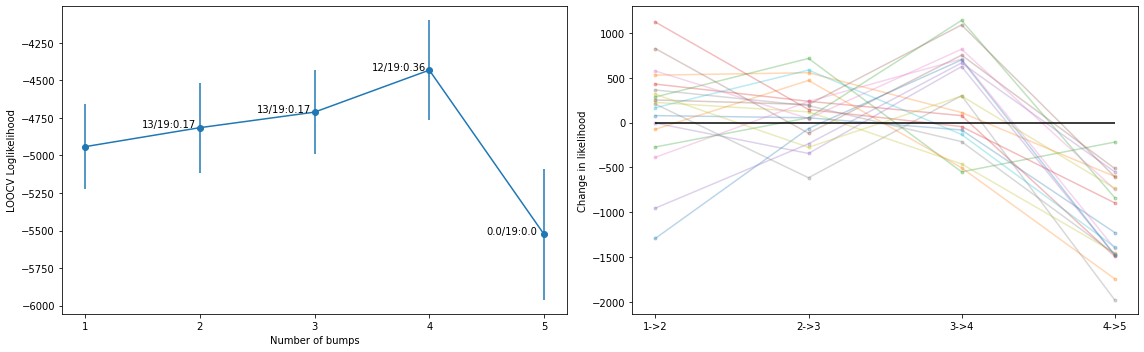

In [16]:
hsmm.plot_LOOCV(loocv_accuracy)

# Inspecting best model

In [21]:
estimates_speed = bests_speed.sel(n_bumps=3).drop_vars('n_bumps')
estimates_accuracy = bests_accuracy.sel(n_bumps=4).drop_vars('n_bumps')

### Bump probabilities

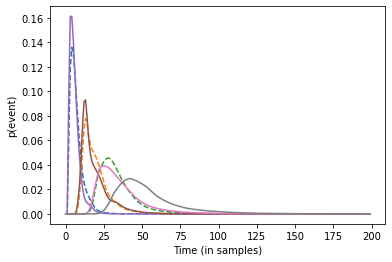

In [22]:
plt.plot(estimates_speed.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]),'--')
plt.plot(estimates_accuracy.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]))
plt.ylabel('p(event)')
plt.xlabel('Time (in samples)');

### Gamma distribution of stages

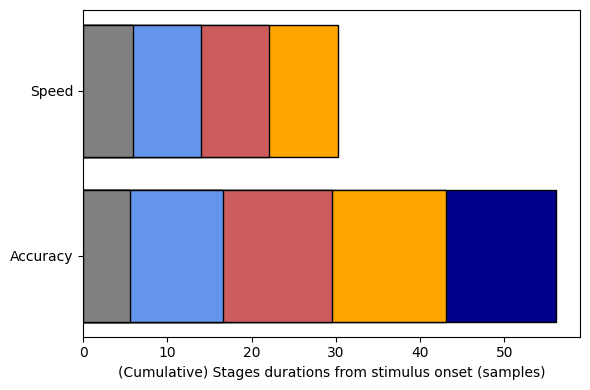

In [29]:
f, axs = plt.subplots(1,1, figsize=(6, 4),sharey=True, sharex=False,dpi=100)

cond = ['Speed', 'Accuracy']
color_code = ['gray','cornflowerblue','indianred','orange','darkblue']
stages_accuracy = estimates_accuracy.parameters.isel(params=0).dropna('stage') * estimates_accuracy.parameters.isel(params=1).dropna('stage')
stages_speed = estimates_speed.parameters.isel(params=0).dropna('stage') * estimates_speed.parameters.isel(params=1).dropna('stage')

j = 0
for i in np.arange(len(stages_accuracy),0,-1):
    plt.barh(-.5, stages_accuracy[:i].sum(), color=color_code[i-1], edgecolor='k')
    if i <= len(stages_speed):
        plt.barh(.5, stages_speed[:i].sum(), color=color_code[i-1], edgecolor='k')
    j-=1
plt.yticks([.5,-.5],["Speed","Accuracy"])
plt.xlabel('(Cumulative) Stages durations from stimulus onset (samples)')
plt.tight_layout()
plt.show()

### Topography of bumps

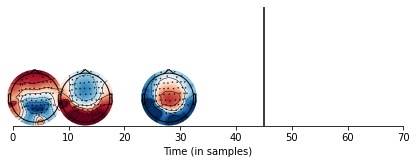

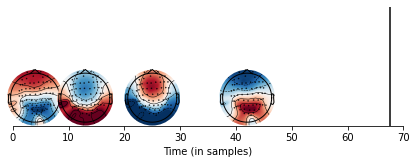

In [28]:
hsmm.plot_topo_timecourse(init_speed, hsmm_speed_data, PCs, estimates_speed, raw, magnify=2, figsize=(7,2),max_time=70)
hsmm.plot_topo_timecourse(init_accuracy, hsmm_accuracy_data, PCs, estimates_accuracy, raw, magnify=2, figsize=(7,2),max_time=70)